# First Year Project - ITU CPH

## Project 3 - Effectiveness of Skin Cancer Prediction

This notebook contains all of the code developed for project 3, completing tasks similar to data scientists working for a dermatologist to investigate whether some characteristics of skin lesions can be reliably measure with a smartphone app.

The goal is to measure at least 2 of the following characteristics in a set of skin lesion images; asymmetry, border, and color.

Then, we will try to assess how good the measurements are, by predicting the diagnosis of the skin lesions based on these features.

We will focus on the **Melanoma** form of skin cancer.

Group 3:<br>
Crisanna Cornish (ccor@itu.dk)<br>
Danielle Dequin (ddeq@itu.dk)<br>
Gino Franco Fazzi (gifa@itu.dk)<br>
Moneeca Abru Iftikhar Latif (abml@itu.dk)<br>
Carl August Wismer (cwis@itu.dk)

Created: 07-04-2021<br>
Last Modified: 09-04-2021

# Data Sources

Data was provided by the ISIC challenge data sets. <br>
https://challenge.isic-archive.com/data

Codella N, Gutman D, Celebi ME, Helba B, Marchetti MA, Dusza S, Kalloo A, Liopyris K, Mishra N, Kittler H, Halpern A. "Skin Lesion Analysis Toward Melanoma Detection: A Challenge at the 2017 International Symposium on Biomedical Imaging (ISBI), Hosted by the International Skin Imaging Collaboration (ISIC)". arXiv: 1710.05006 [cs.CV]


# Imports

In [ ]:
!pip install scikit-image
!pip install pillow

     |████████████████████████████████| 30.2 MB 730 kB/s 
     |████████████████████████████████| 3.3 MB 30.9 MB/s 
     |████████████████████████████████| 165 kB 34.9 MB/s 
     |████████████████████████████████| 4.4 MB 32.9 MB/s 
     |████████████████████████████████| 1.6 MB 56.2 MB/s 
  Attempting uninstall: decorator
    Found existing installation: decorator 5.0.6
    Not uninstalling decorator at /shared-libs/python3.8/py-core/lib/python3.8/site-packages, outside environment /root/venv
    Can't uninstall 'decorator'. No files were found to uninstall.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
from math import pi
from math import sqrt
from skimage import morphology
from skimage.morphology import opening
from skimage import transform
from skimage import filters
from skimage.filters import sobel
from skimage.segmentation import disk_level_set
from PIL import Image

# Paths

In [ ]:
IMG_PATH = '../data/example_image/'
SUPER_IMG_PATH = '../data/example_image/'
SEG_PATH = '../data/example_segmentation/'

TRUTH = '../data/example_ground_truth.csv'
FEATURES = '../features/features.csv'

# Functions

In [ ]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray


def masker(image, sens):
    '''takes image and returns a masked image'''
    gray = rgb2gray(image) #create grayscale thingy
    img2 = gray < sens # **This level needs manually adjusting, also need to be able to automate**
    
    return img2.astype(int)

def dimensions(mask1):
    '''calculates height(max) and width(90 deg to height)
        returns height, width, rotated mask image, degree of rotation'''
    pixels_in_col = np.max(np.sum(mask1, axis=0))

    rot = 0
    max_col = 0
    rot_max = 0
    for _ in range(9):
        rot_im = transform.rotate(mask1,rot)
        pixels_in_col = np.max(np.sum(rot_im, axis=0))
        if pixels_in_col > max_col:
            max_col = pixels_in_col
            rot_max = rot
            pixels_in_row = np.max(np.sum(rot_im, axis=1))
        rot += 10

    return max_col, pixels_in_row, rot_max

def perimeter(mask1):
    '''calcs mask perimeter, returns outline image and length of perimeter'''
    struct_el = morphology.disk(1)
    mask_eroded = morphology.binary_erosion(mask1, struct_el)
    image_perimeter = mask1 - mask_eroded

    return image_perimeter, np.sum(image_perimeter)

def predict(bi_image):   
    area = np.sum(bi_image)
    _, peri = perimeter(bi_image)
    
    area_from_peri = pi*((peri/(2*pi))**2)
    peri_from_area = 2*pi*sqrt(area/pi)
    
    return area, area_from_peri, peri, peri_from_area

In [ ]:
def get_boundaries(image):
    mask = np.where(image == 1)
    left = min(mask[1])
    right = max(mask[1])
    upper = min(mask[0])
    lower = max(mask[0])
    return upper, lower, left, right

def get_center(image):
    up, dw, lt, rt = get_boundaries(image)
    center = ((up + dw)//2,(rt + lt)//2)
    return center
    
def zoom(image):
    up, dw, lt, rt = get_boundaries(image)
    if ((up+dw) % 2) != 0:
        dw +=1 
    if ((rt+lt) % 2) != 0:
        rt +=1
    rectangle = image[up:dw, lt:rt]
    return rectangle


def test_symmetry(image, rot_deg=30):

    assert (rot_deg <= 90) and (rot_deg >= 0), "Rotation degree should be positive and at most 90 deg"
    optimal = 0
    
    for deg in range(0,90, rot_deg):
        rot_image = skimage.transform.rotate(image, deg)
        z = zoom(rot_image)
        
        upside, downside, leftside, rightside = cuts(z)

        up_dw = np.sum(np.bitwise_and(upside.astype(int), np.flipud(downside).astype(int))) /\
        np.sum(np.bitwise_or(upside.astype(int), np.flipud(downside).astype(int)))

        lt_rt = np.sum(np.bitwise_and(leftside.astype(int), np.fliplr(rightside).astype(int))) /\
        np.sum(np.bitwise_or(leftside.astype(int), np.fliplr(rightside).astype(int)))
    
        symmetry = (up_dw+lt_rt)/2
        
        if symmetry > optimal: optimal = symmetry

    return symmetry
    
    if show:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,12), dpi=350)
        ax1.imshow(upside)
        ax2.imshow(downside)
        ax3.imshow(leftside)
        ax4.imshow(rightside)

        print(f'Up/Down Symmetry: {up_dw:.2%}')
        print(f'Left/Right Symmetry: {lt_rt:.2%}')
    
    else:
        return symmetry
    

# Import Single Image and Explore Data

(2016, 3024, 3)
uint8
(2016, 3024)


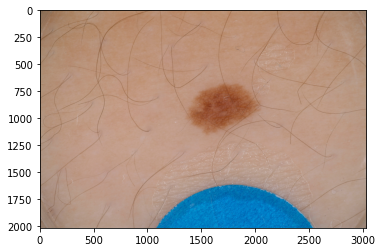

In [ ]:
IMG = 'ISIC_0001769'

image = plt.imread(IMG_PATH+IMG+'.jpg')
mask1 = plt.imread(SEG_PATH+IMG+'_segmentation.png')

print(image.shape)
print(image.dtype)
print(mask1.shape)

plt.imshow(image, cmap='gray');

Color in a random spot:  [  0 121 196]
Color in the lesion:  [195 158 140]


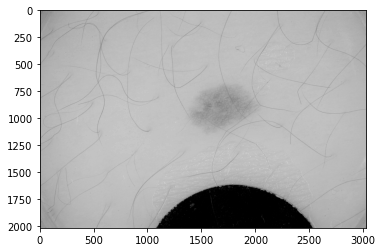

In [ ]:
# Get a single RGB value from the blue circle (marker used by dermatologist)
print(f"Color in a random spot: ", image[2000,2000,:])

# Find color of a random spot
print(f"Color in the lesion: ", image[1500,1000,:])

# Show only the red channel
plt.imshow(image[:,:,0], cmap='gray');

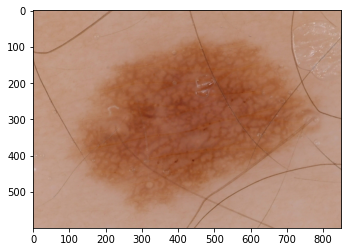

In [ ]:
# Display only a part of the image
im_part = image[600:1200,1250:2100,:]
plt.imshow(im_part);

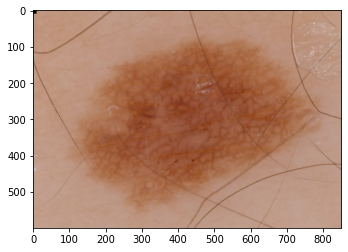

In [ ]:
# Modify the image by setting some pixels to black
im_copy = im_part.copy()

im_copy[0:10,0:10,:] = np.tile(0, [10, 10, 3])
plt.imshow(im_copy);

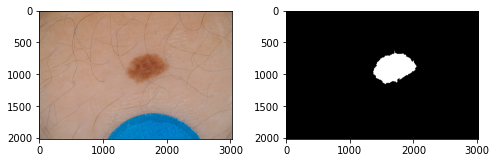

In [ ]:
# Load Image and Segmentation Image Side by Side
image = plt.imread(IMG_PATH+IMG+'.jpg')
im_seg = plt.imread(SEG_PATH+IMG+'_segmentation.png')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 5))
axes[0].imshow(image)
axes[1].imshow(im_seg, cmap='gray')
fig.tight_layout()

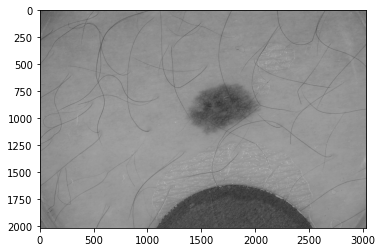

In [ ]:
# See the results of the rgb2gray function

gray = rgb2gray(image)
plt.imshow(gray, cmap='gray');

In [ ]:
# A histogram of the range of gray values
#plt.hist(gray);

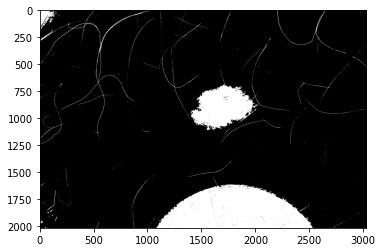

In [ ]:
# Filtering the image based on the gray value
im_gray = gray < 125
plt.imshow(im_gray, cmap='gray')

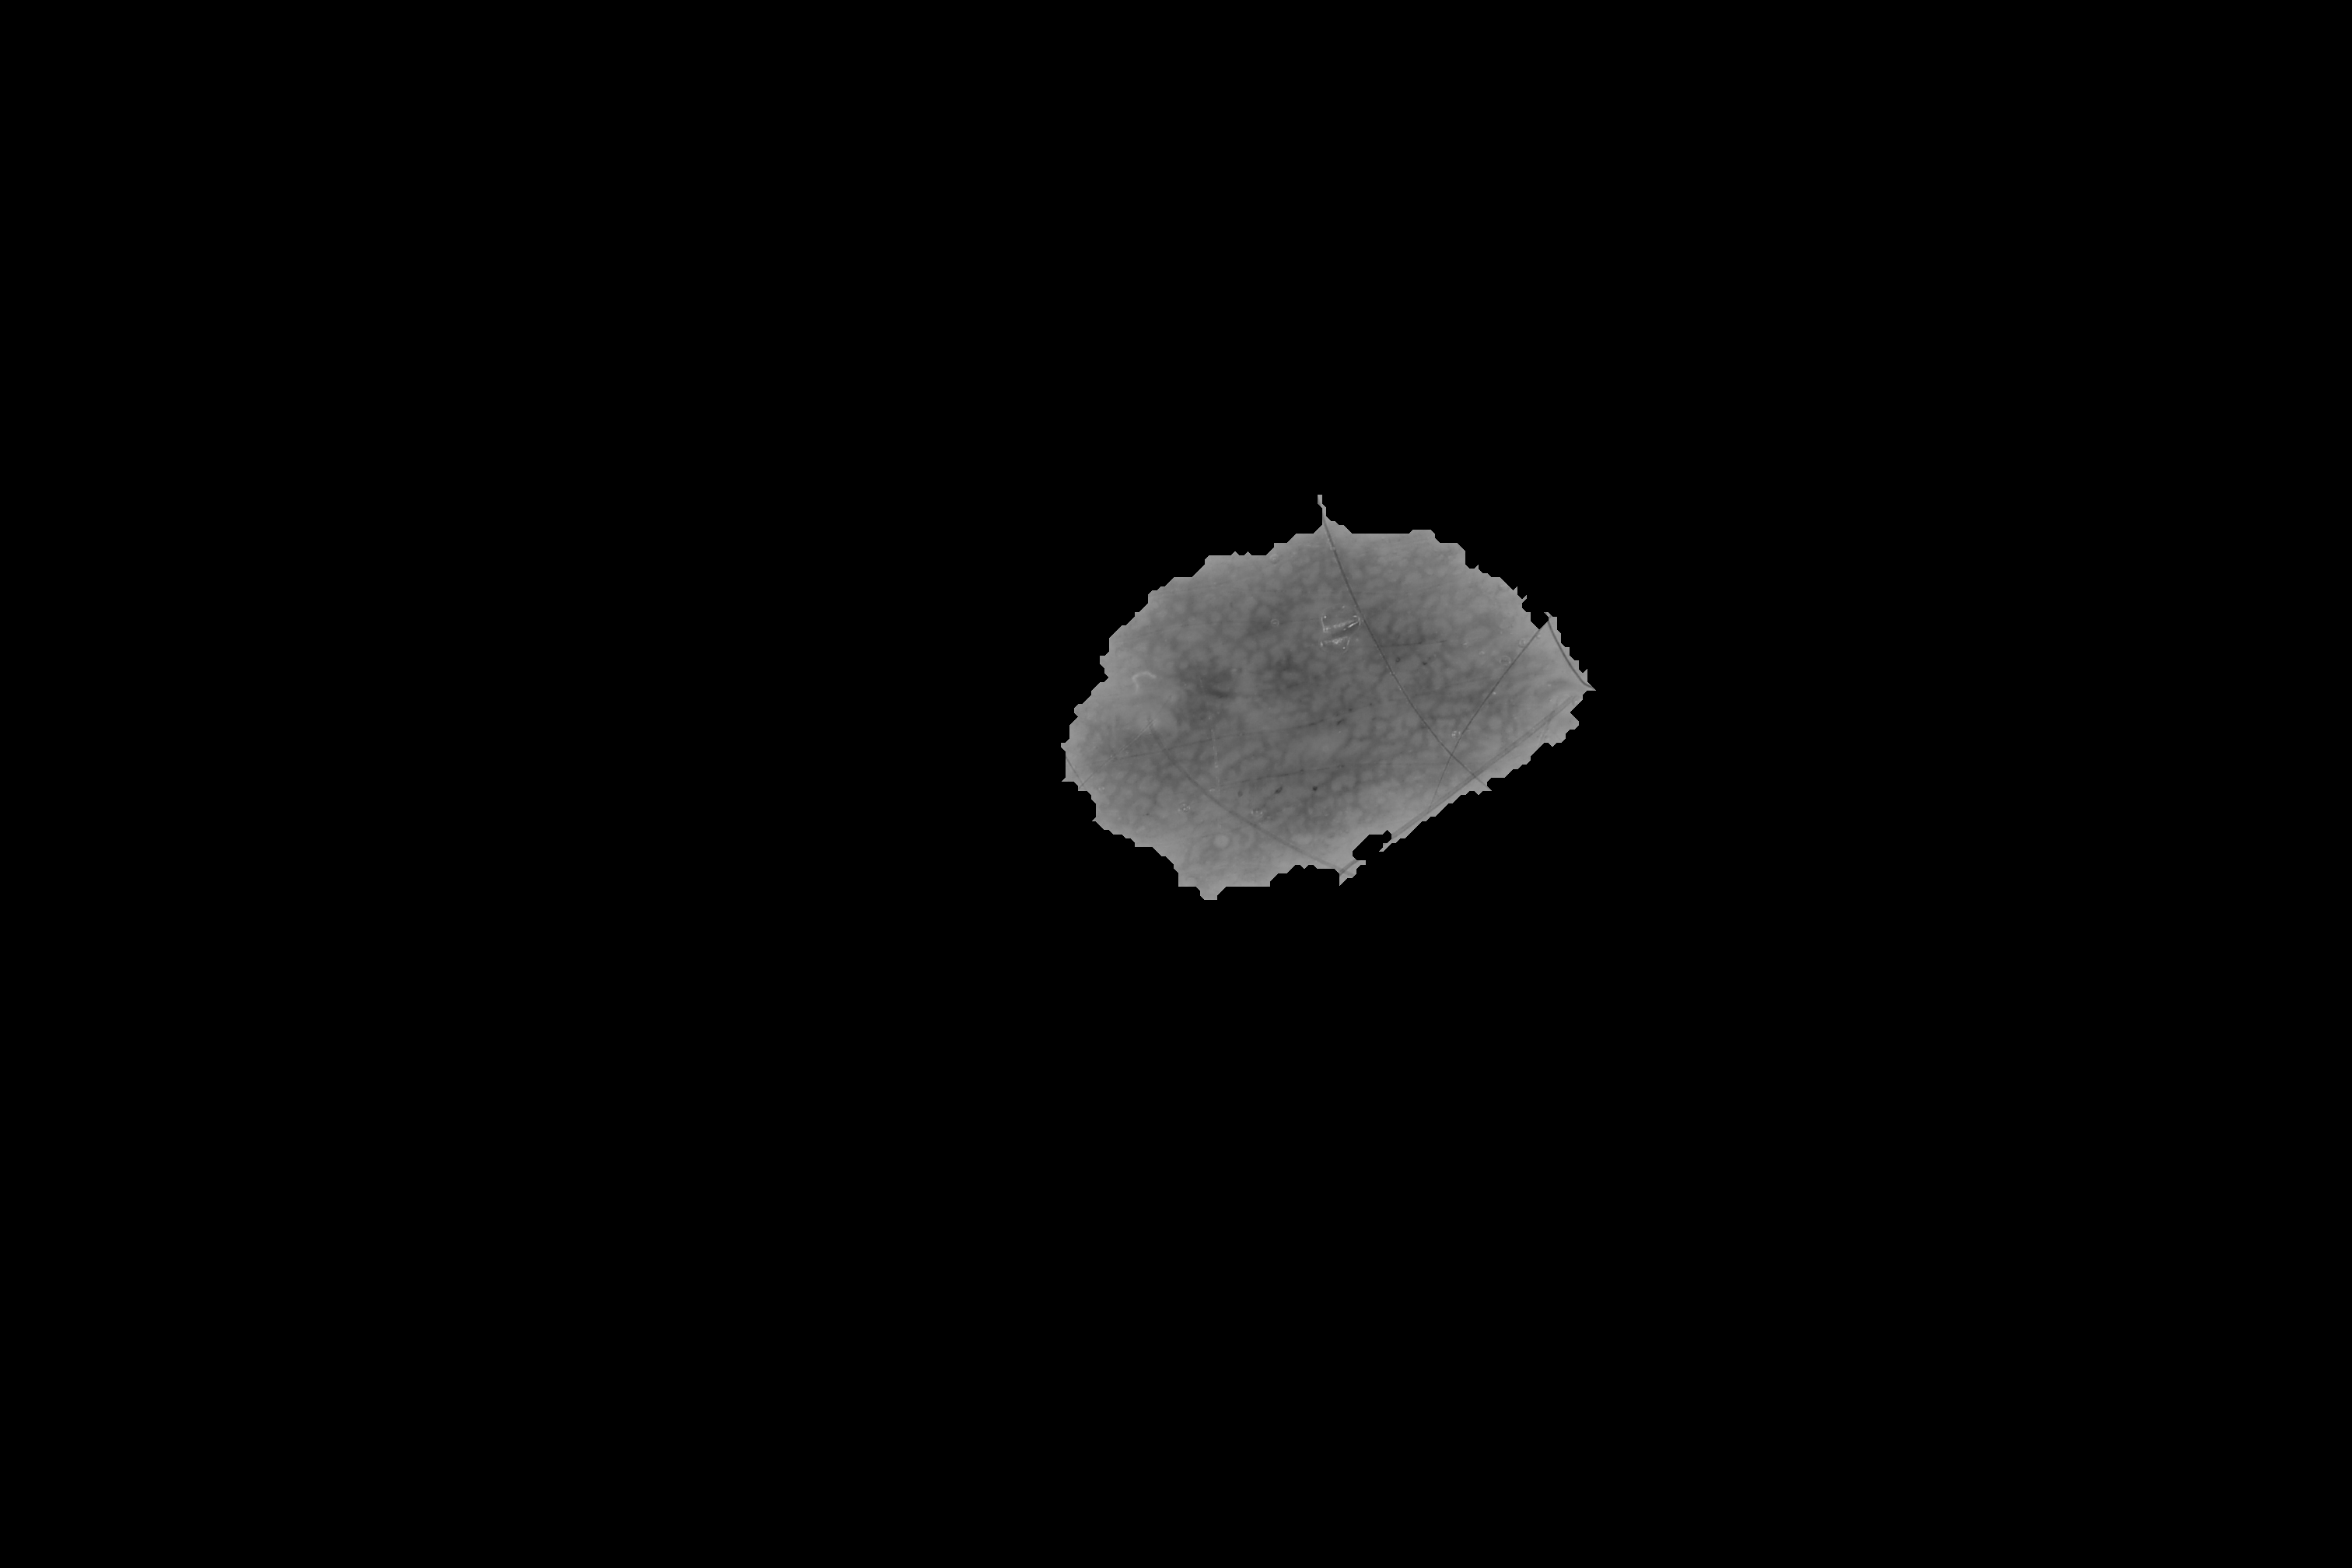

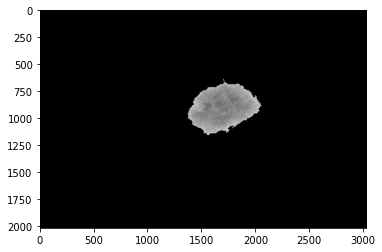

In [ ]:
# Load images as Pillow Image objects
im1 = Image.open(IMG_PATH+IMG+'.jpg')
im2 = Image.open(SEG_PATH+IMG+'_segmentation.png')

# Overlay the images
im2.paste(im1, (0,0), mask = im2)

# Display the overlayed image
im2.show() # This works on Jupyter notebooks, but not deepnote
plt.imshow(im2,cmap='gray');

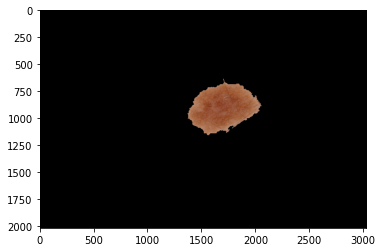

In [ ]:
# Remove everything but the lesion using the mask
im3 = image.copy()
im3[mask1==0] = 0

plt.imshow(im3);

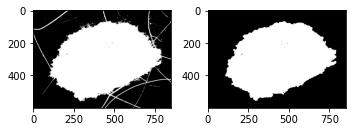

In [ ]:
mask2 = masker(im_part, 150)

struct_el = morphology.disk(5)
opened = opening(mask2, struct_el)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].imshow(mask2, cmap='gray')
axes[1].imshow(opened, cmap='gray')
fig.tight_layout()

Length: 2370.00


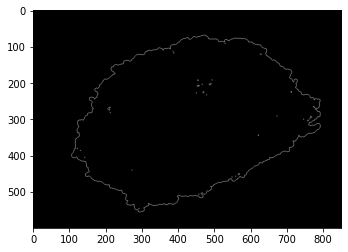

In [ ]:
peri_img, peri = perimeter(opened)

print(f'Length: {peri:.2f}')

plt.imshow(peri_img, cmap='gray');

In [ ]:
truth = pd.read_csv(TRUTH)

In [ ]:
working = truth[25:35].copy()
processed = pd.DataFrame(columns = ['id','perimeter','area', 'ref_area','ratio', 'peri', 'mask','image', 'melanoma','keratosis'])

c= 0

for image in working['image_id']:
    
    image2 = plt.imread(IMG_PATH+image+'.jpg')
    mask1 = plt.imread(SEG_PATH+image+'_segmentation.png')

    #plt.imshow(mask1, cmap='gray');

    mask = np.where(mask1 == 1)

    x_min = min(mask[0])
    if x_min > 100:
        x_min -= 100
    else:
        x_min = 0
    y_min = min(mask[1])
    if y_min > 100:
        y_min -= 100
    else:
        y_min = 0

    x_max = max(mask[0])+100
    y_max = max(mask[1])+100
    
    image3 = image2[x_min:x_max,y_min:y_max]
    
    area_1 = np.sum(mask1)
    
    mask2 = masker(image3, 120)
    area = np.sum(mask2)
    
    peri_img, peri = perimeter(mask2)
   
    processed.loc[c] = [image, peri,area, area_1, area/area_1, peri_img, mask2,image3, working[working['image_id'] == image].iloc[0]['melanoma'], working[working['image_id'] == image].iloc[0]['seborrheic_keratosis']]
    c+=1

In [ ]:
test = -1
sorted_processed = processed.sort_values(by=['ratio'], ignore_index=True)
sorted_processed

,id,perimeter,area,ref_area,ratio,peri,mask,image,melanoma,keratosis
0,ISIC_0012160,376,684,109831.0,0.006228,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[179, 166, 158], [178, 165, 157], [179, 164,...",0,0
1,ISIC_0012159,1593,2494,328058.0,0.007602,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[169, 134, 128], [168, 133, 127], [170, 137,...",0,0
2,ISIC_0012151,80304,1013294,1558295.0,0.650258,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[189, 173, 160], [189, 173, 160], [189, 173,...",1,0
3,ISIC_0012099,1692,62009,88455.0,0.701023,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[201, 181, 182], [200, 180, 181], [200, 180,...",1,0
4,ISIC_0012126,2357,58421,75301.0,0.775833,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[184, 170, 161], [185, 171, 162], [184, 170,...",0,0
5,ISIC_0012109,2570,105885,129415.0,0.818182,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[179, 161, 141], [179, 160, 143], [181, 162,...",0,0
6,ISIC_0012201,7269,334762,361298.0,0.926554,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[164, 139, 117], [163, 138, 116], [164, 137,...",0,0
7,ISIC_0012143,159557,2042197,1124326.0,1.816374,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[145, 116, 118], [149, 119, 119], [146, 116,...",0,1
8,ISIC_0012191,75218,448256,221207.0,2.026410,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[[150, 101, 69], [150, 101, 69], [147, 98, 65...",0,0
9,ISIC_0012127,9119,260357,106564.0,2.443198,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[[156, 99, 80], [156, 99, 80], [158, 100, 80]...",0,0


0 ISIC_0012160 376 0.006227749906674801


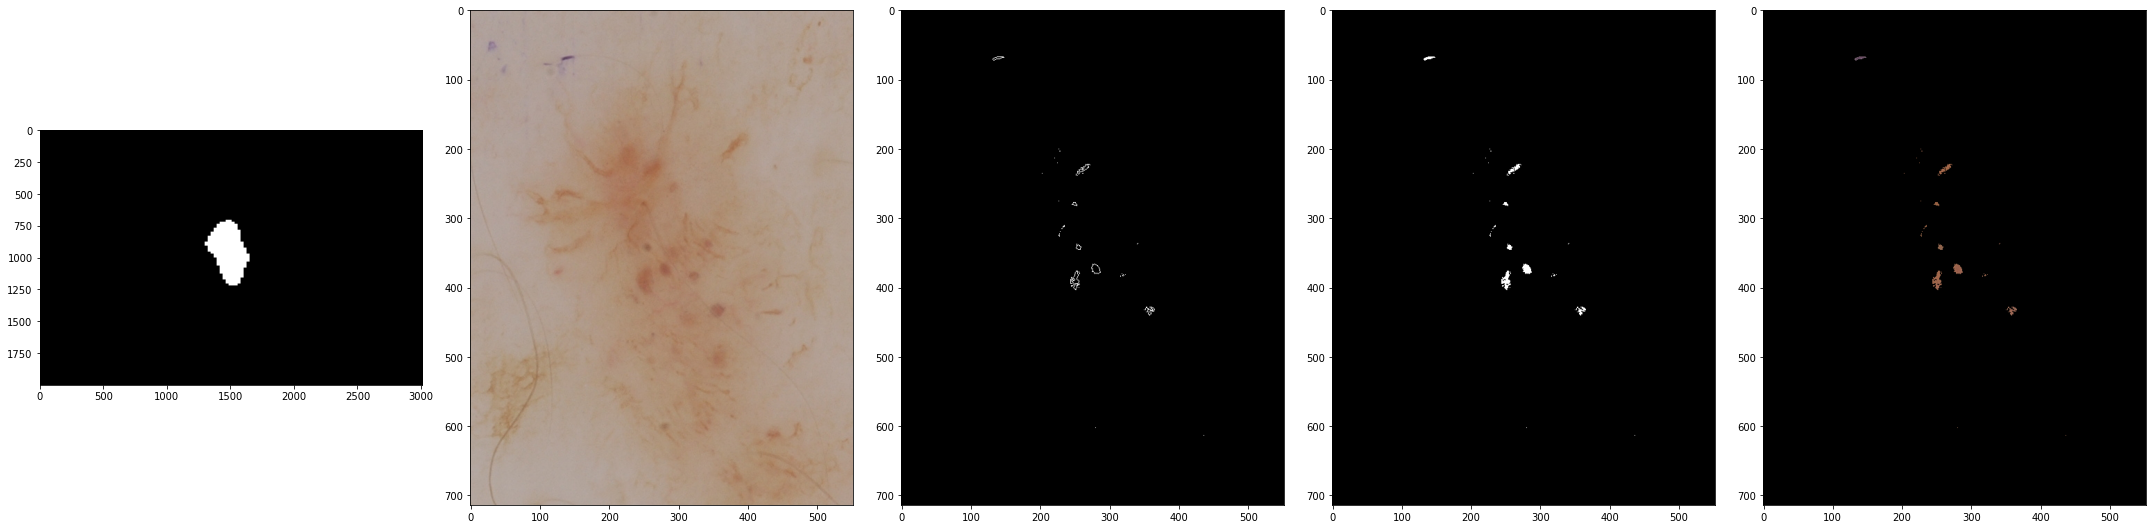

In [ ]:
test = test+1

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30, 20))
axes.flatten()

print(test, sorted_processed['id'][test],sorted_processed['perimeter'][test], sorted_processed['ratio'][test])


o_mask = plt.imread(SEG_PATH+sorted_processed['id'][test]+'_segmentation.png')
im3 = sorted_processed['image'][test].copy()
im3[sorted_processed['mask'][test]==0] = 0

axes[1].imshow(sorted_processed['image'][test], cmap='gray')
axes[0].imshow(o_mask, cmap='gray')
axes[2].imshow(sorted_processed['peri'][test],cmap='gray')
axes[3].imshow(sorted_processed['mask'][test],cmap='gray')
axes[4].imshow(im3, cmap='gray')

fig.tight_layout();

# Image Dimensions

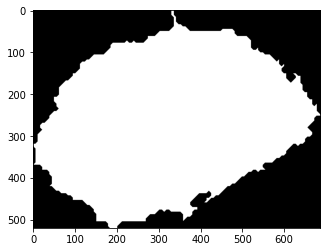

In [ ]:
image = plt.imread(IMG_PATH+IMG+'.jpg')
mask1 = plt.imread(SEG_PATH+IMG+'_segmentation.png')

plt.imshow(mask1, cmap='gray');

mask = np.where(mask1 == 1)

x_min = min(mask[0])
#if x_min > 150:
#    x_min -= 150
#else:
#    x_min = 0
y_min = min(mask[1])
#if y_min > 150:
#    y_min -= 150
#else:
#    y_min = 0
    
x_max = max(mask[0])#+150
y_max = max(mask[1])#+150

# Crop the image based on min and max values
image_crop = image[x_min:x_max,y_min:y_max]
mask1_crop = mask1[x_min:x_max,y_min:y_max]

plt.imshow(mask1_crop, cmap='gray');

357240 216142.0
60.50330310155637


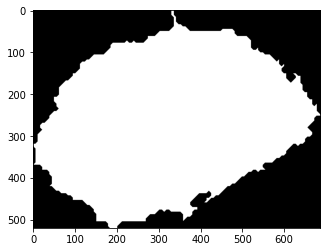

In [ ]:
# Total size of the image
total = mask1_crop.shape[0] * mask1_crop.shape[1] 

# Size of mask only
area = np.sum(mask1_crop) # this matches the given area in the features csv

print(total, area)

# As percentage
print(area/total*100)

plt.imshow(mask1_crop, cmap='gray');

Height: 693.85 
Width: 448.63

Height: 469.0 
Width: 655.0


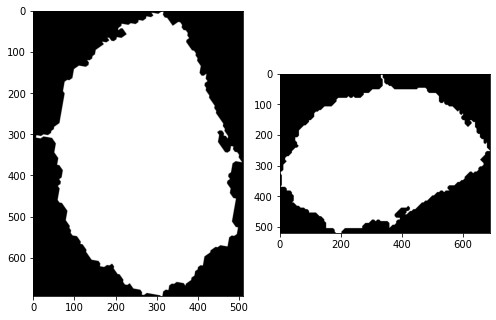

In [ ]:
# Height and width of Lesion
height, width, rot_max = dimensions(mask1)

# Rotate Image based on (what exactly are the outputs of dimensions?)
rot_img = transform.rotate(mask1,rot_max)

# Another way to measure height/width
pixels_in_col = np.max(np.sum(mask1_crop,axis=0))
pixels_in_row = np.max(np.sum(mask1_crop,axis=1))

print(f'Height: {height:.2f} \nWidth: {width:.2f}')
print('')
print(f'Height: {pixels_in_col} \nWidth: {pixels_in_row}')
x = 455
y = 1170

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 5))
axes[0].imshow(rot_img[x:x+693,y:y+510], cmap='gray')
axes[1].imshow(mask1_crop, cmap='gray')
fig.tight_layout();

# Lesion Perimeter

Length: 692.92
Length: 1987.00


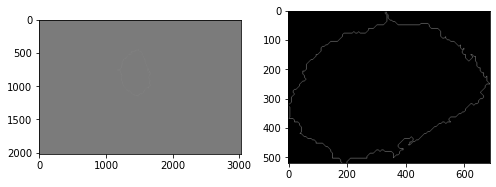

In [ ]:
image_perimeter, peri = perimeter(rot_img)
img_2, peri2 = perimeter(mask1_crop) #the non-rotated image matches the features.csv

print(f'Length: {peri:.2f}')
print(f'Length: {peri2:.2f}') #not sure why these would be different... bit concerning

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 5))
axes[0].imshow(image_perimeter, cmap='gray')
axes[1].imshow(img_2, cmap='gray')
fig.tight_layout();

216142.0
177421


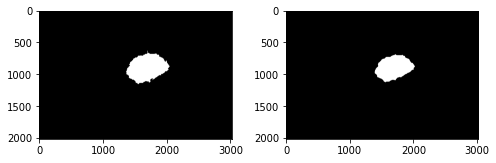

In [ ]:
# Structural element, used as a brush on the mask
struct_el = morphology.disk(20)

mask_eroded = morphology.binary_erosion(mask1,struct_el)

# Show original and eroded side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))
axes[0].imshow(mask1, cmap='gray')
axes[1].imshow(mask_eroded, cmap='gray')
fig.tight_layout()

# Verify it's smaller
print(area)
print(np.sum(mask_eroded))

38739.0


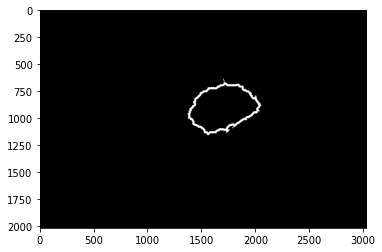

In [ ]:
# Subtract the two masks from each other to get the border/perimeter
image_perimeter = mask1 - mask_eroded

plt.imshow(image_perimeter, cmap='gray')

# length of the perimeter (will only be a 'true' length if the brush is 1)
print(np.sum(image_perimeter))

In [ ]:
'''I was trying to compare the lesion to the 'perfect circle'
that would share the same area/perimeter. I was hoping deviations
from this would be more pronounced in cancerous lesions, but meh.'''

rad_from_peri = peri/(2*pi) #calc radius of the circle with matching circumference
rad_from_area = sqrt(area/pi) #calc radius of the circle with matching area

est_circ = 2*pi*rad_from_area #calc circumference of the circle with matching area
est_area = pi*rad_from_peri**2 #calc area of the circle with match circumference

#print the differences between the actual and circle circumference and areas.
print(f'Difference in circumference: {abs(peri-est_circ):.2f} \nDifference in area: {abs(area-est_area):.2f}')

Difference in circumference: 955.15 
Difference in area: 177933.99


# Testing Symmetry

In [ ]:
test_symmetry(mask1)

NameError: name 'cuts' is not defined

# Load Dataframes

In [ ]:
truth = pd.read_csv(TRUTH)
features = pd.read_csv(FEATURES)

truth.head()

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0001769,0,0
1,ISIC_0001852,0,0
2,ISIC_0001871,0,0
3,ISIC_0003462,0,0
4,ISIC_0003539,0,0


In [ ]:
cancer = truth[truth['melanoma'] == 1]
cancer.shape

(404, 3)

In [ ]:
merged_features = features.merge(truth, left_on=['id'],right_on=['image_id'])
merged_features.head()

,id,area,perimeter,image_id,melanoma,seborrheic_keratosis
0,ISIC_0001769,216160.0,2013.0,ISIC_0001769,0,0
1,ISIC_0001852,130493.0,1372.0,ISIC_0001852,0,0
2,ISIC_0001871,205116.0,1720.0,ISIC_0001871,0,0
3,ISIC_0003462,161705.0,1344.0,ISIC_0003462,0,0
4,ISIC_0003539,317040.0,2063.0,ISIC_0003539,0,0


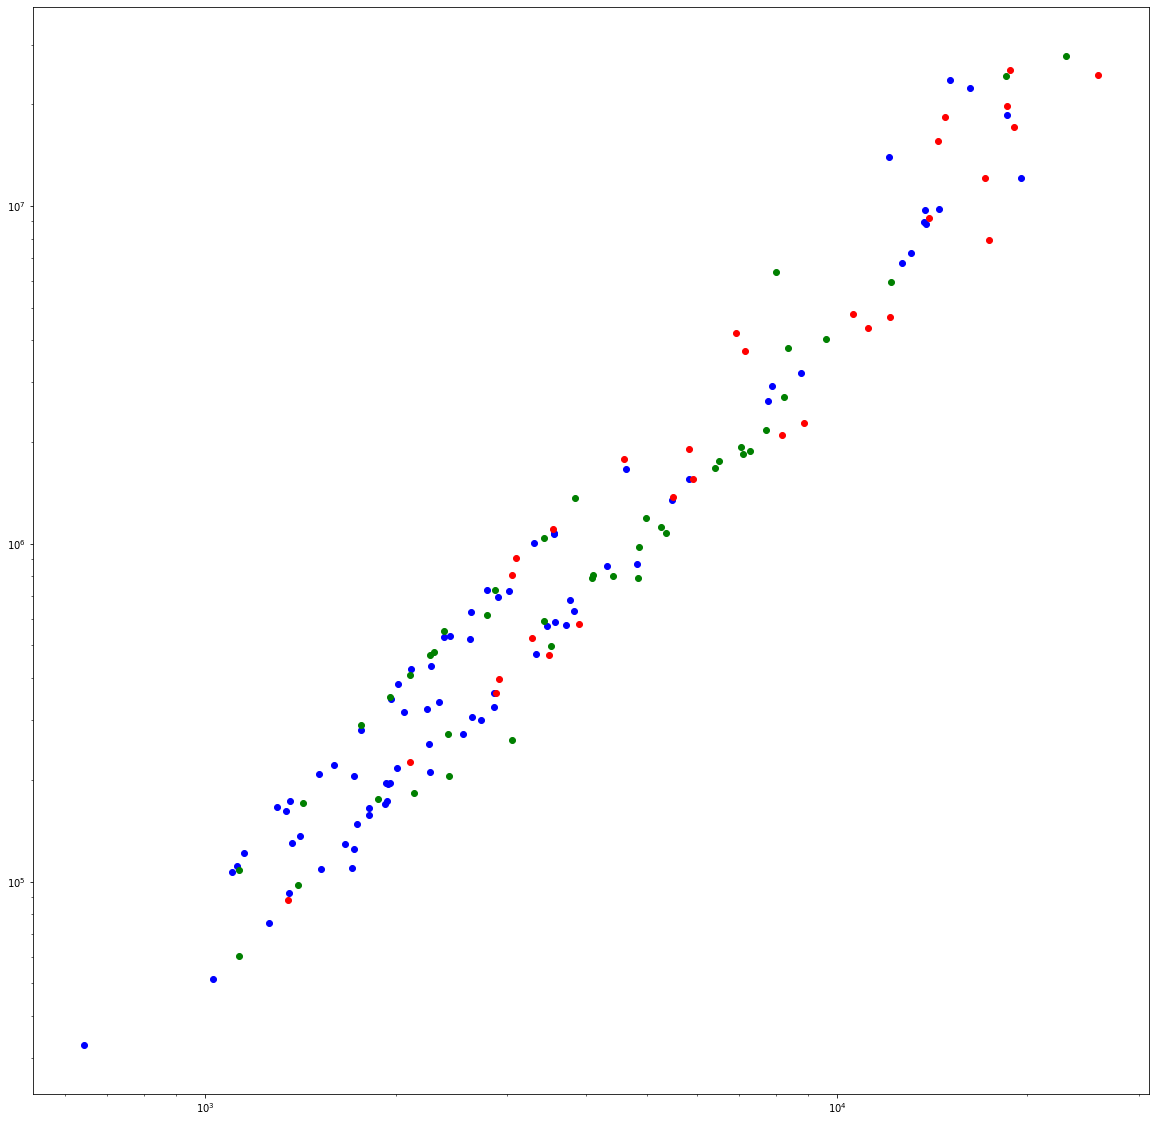

In [ ]:
mel = merged_features[merged_features['melanoma']==1.0]
kera = merged_features[merged_features['seborrheic_keratosis']==1.0]
clear = merged_features[(merged_features['melanoma']==0.0) & (merged_features['seborrheic_keratosis']==0.0)]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))

plt.scatter(clear['perimeter'], clear['area'], c='blue')
plt.scatter(kera['perimeter'], kera['area'], c='green')
plt.scatter(mel['perimeter'], mel['area'], c='red')
plt.xscale('log')
plt.yscale('log');

In [ ]:
#Look at colour...
IMG = 'ISIC_0012254'
image = plt.imread(IMG_PATH+IMG+'.jpg')
mask1 = plt.imread(SEG_PATH+IMG+'_segmentation.png')


def colour(image, mask, show=False):
    
    rgb = image.copy()
    
    rgb[mask==0]= 0
    
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    
    area = np.sum(mask)
    
    r_av = (r.sum()/area) #average r value
    g_av = (g.sum()/area) #average g value
    b_av = (b.sum()/area) #average b value
    
    difference_r = rgb[:,:,0] - r_av #find the difference 
    difference_g = rgb[:,:,1] - g_av
    difference_b = rgb[:,:,2] - b_av
    
    difference_r[difference_r == -r_av] = 0
    difference_g[difference_g == -g_av] = 0
    difference_b[difference_b == -b_av] = 0
    
    #plt.imshow(difference_r, cmap='gray')
    #print(mask.shape, difference_r.shape)
    
    if show:
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
        axes = axes.flatten()

        axes[0].imshow(rgb)
        axes[1].imshow(r, cmap='gray')
        axes[2].imshow(g, cmap='gray')
        axes[3].imshow(b, cmap='gray')
        fig.tight_layout()
    
    return np.absolute(difference_r).sum()/area,np.absolute(difference_g).sum()/area,np.absolute(difference_b).sum()/area


r,g,b = colour(image, mask1)
#print(r,g,b)

In [ ]:
rgb_truth = truth.copy()
R=[]
G=[]
B=[]
T = []
c=0

for name in rgb_truth['image_id']:
    i = plt.imread(IMG_PATH+name+'.jpg')
    m = plt.imread(SEG_PATH+name+'_segmentation.png')
    
    r,g,b = colour(i, m)
    t = r+g+b
    R.append(r)
    G.append(g)
    B.append(b)
    T.append(t)
    #print((r,g,b))
    
    c+=1
    
rgb_truth.insert(0, 'r', R)
rgb_truth.insert(0, 'g', G)
rgb_truth.insert(0, 'b', B)
rgb_truth.insert(0, 't', T)


KeyboardInterrupt: 

In [ ]:
mel = rgb_truth[rgb_truth['melanoma']==1.0]
kera = rgb_truth[rgb_truth['seborrheic_keratosis']==1.0]
clear = rgb_truth[(rgb_truth['melanoma']==0.0) & (rgb_truth['seborrheic_keratosis']==0.0)]
                  
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
axes = axes.flatten()
b = 30
d = False
axes[0].hist(clear['r'], bins=b, color='red', density=d)
axes[1].hist(clear['g'], bins=b,color='green', density=d)
axes[2].hist(clear['b'], bins=b,color='blue', density=d);

axes[3].hist(mel['r'], bins=b,color='red', density=d)
axes[4].hist(mel['g'], bins=b,color='green', density=d)
axes[5].hist(mel['b'], bins=b,color='blue', density=d);

axes[6].hist(kera['r'], bins=b,color='red', density=d)
axes[7].hist(kera['g'], bins=b,color='green', density=d)
axes[8].hist(kera['b'], bins=b,color='blue', density=d);

axes[0].set_title('clear red channel')
axes[1].set_title('clear green channel')
axes[2].set_title('clear blue channel')

axes[3].set_title('mel red channel')
axes[4].set_title('mel green channel')
axes[5].set_title('mel blue channel')

axes[6].set_title('kera red channel')
axes[7].set_title('kera green channel')
axes[8].set_title('kera blue channel');

for i in range(9):
    axes[i].set_ylim([0,14])
    axes[i].set_xlim(0,70);

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 20))
axes = axes.flatten()
b = 30
d = True
axes[0].hist(clear['t'], bins=b, color='purple', density=d)

axes[1].hist(mel['t'], bins=b,color='purple', density=d)

axes[2].hist(kera['t'], bins=b,color='purple', density=d)

axes[0].set_title('clear all channel')
axes[1].set_title('mel all channel')
axes[2].set_title('kera all channel');

for i in range(3):
    axes[i].set_ylim([0,0.035])
    axes[i].set_xlim(0,250);

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=16085576-0af6-4fbb-80e7-c9ae882b63ec' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>